## Markov Game

In [1]:
struct MG
    γ  # discount factor
    ℐ  # agents
    𝒮  # state space
    𝒜  # joint action space
    T  # transition function
    R  # joint reward function
end

## Utilities

##### Simple Game Policy

In [18]:
struct SimpleGamePolicy
    p::Dict

    function SimpleGamePolicy(p::Base.Generator)
        return SimpleGamePolicy(Dict(p))
    end

    function SimpleGamePolicy(d::Dict)
        vs = collect(values(d))
        vs ./= sum(vs) #normalize
        return new(Dict(k => v for (k,v) in zip(keys(d), vs)))
    end

    SimpleGamePolicy(ai) = new(Dict(ai => 1.0))
end

(πi::SimpleGamePolicy)(ai) = get(πi.p, ai, 0.0)
(πi::SimpleGamePolicy)() = rand(SetCategorical(collect(keys(πi.p)), collect(values(πi.p))))

joint(X) = vec(collect(Iterators.product(X...)))
joint(π, πi, i) = [i == j ? πi : πj for (j, πj) in enumerate(π)]

joint (generic function with 3 methods)

##### Markov Game Policy

In [4]:
struct MGPolicy
    p # dictionary mapping states to simple game policies
    MGPolicy(p::Base.Generator) = new(Dict(p))
end

(πi::MGPolicy)(s, ai) = πi.p[s](ai)
(πi::SimpleGamePolicy)(s, ai) = πi(ai)

probability(𝒫::MG, s, π, a) = prod(πj(s, aj) for (πj, aj) in zip(π, a))
reward(𝒫::MG, s, π, i) =
    sum(𝒫.R(s, a)[i] * probability(𝒫, s, π, a) for a in joint(𝒫.𝒜))
transition(𝒫::MG, s, π, s′) =
    sum(𝒫.T(s, a, s′) * probability(𝒫, s, π, a) for a in joint(𝒫.𝒜))

transition (generic function with 1 method)

##### Categorical

In [5]:
using Distributions
using LinearAlgebra

struct SetCategorical{S}
    elements::Vector{S} # Set elements (could be repeated)
    distr::Categorical # Categorical distribution over set elements
    
    function SetCategorical(elements::AbstractVector{S}) where S
        weights = ones(length(elements))
        return new{S}(elements, Categorical(normalize(weights,1)))
    end
        
    function SetCategorical(elements::AbstractVector{S}, weights::AbstractVector{Float64}) where S
        ℓ₁ = norm(weights,1)
        if ℓ₁ < 1e-6 || isinf(ℓ₁)
            return SetCategorical(elements)
        end
        distr = Categorical(normalize(weights,1))
        return new{S}(elements,distr)
    end
end

Distributions.rand(D::SetCategorical) = D.elements[rand(D.distr)]
Distributions.rand(D::SetCategorical, n::Int) = D.elements[rand(D.distr, n)]

## Fictitious play

In [6]:
mutable struct MGFictitiousPlay
    𝒫 # Markov game
    i # agent index
    Qi # state-action value estimates
    Ni # state-action counts
end

function MGFictitiousPlay(𝒫::MG, i)
    ℐ, 𝒮, 𝒜, R = 𝒫.ℐ, 𝒫.𝒮, 𝒫.𝒜, 𝒫.R
    Qi = Dict((s, a) => R(s, a)[i] for s in 𝒮 for a in joint(𝒜))
    Ni = Dict((j, s, aj) => 1.0 for j in ℐ for s in 𝒮 for aj in 𝒜[j])
    return MGFictitiousPlay(𝒫, i, Qi, Ni)
end

function (πi::MGFictitiousPlay)(s)
    𝒫, i, Qi = πi.𝒫, πi.i, πi.Qi
    ℐ, 𝒮, 𝒜, T, R, γ = 𝒫.ℐ, 𝒫.𝒮, 𝒫.𝒜, 𝒫.T, 𝒫.R, 𝒫.γ

    πi′(i, s) = SimpleGamePolicy(ai => πi.Ni[i, s, ai] for ai in 𝒜[i])
    πi′(i) = MGPolicy(s => πi′(i, s) for s in 𝒮)
    π = [πi′(i) for i in ℐ]

    U(s, π) = sum(πi.Qi[s, a] * probability(𝒫, s, π, a) for a in joint(𝒜))
    Q(s, π) = reward(𝒫, s, π, i) + γ * sum(transition(𝒫, s, π, s′) * U(s′, π) for s′ in 𝒮)
    Q(ai) = Q(s, joint(π, SimpleGamePolicy(ai), i))

    ai = argmax(Q, 𝒫.𝒜[πi.i])
    return SimpleGamePolicy(ai)
end

function update!(πi::MGFictitiousPlay, s, a, s′)
    𝒫, i, Qi = πi.𝒫, πi.i, πi.Qi
    ℐ, 𝒮, 𝒜, T, R, γ = 𝒫.ℐ, 𝒫.𝒮, 𝒫.𝒜, 𝒫.T, 𝒫.R, 𝒫.γ

    for (j, aj) in enumerate(a)
        πi.Ni[j, s, aj] += 1
    end
    πi′(i, s) = SimpleGamePolicy(ai => πi.Ni[i, s, ai] for ai in 𝒜[i])
    πi′(i) = MGPolicy(s => πi′(i, s) for s in 𝒮)
    π = [πi′(i) for i in ℐ]

    U(π, s) = sum(πi.Qi[s, a] * probability(𝒫, s, π, a) for a in joint(𝒜))
    Q(s, a) = R(s, a)[i] + γ * sum(T(s, a, s′) * U(π, s′) for s′ in 𝒮)
    for a in joint(𝒜)
        πi.Qi[s, a] = Q(s, a)
    end
    
    return [π[i].p for i in ℐ]
end

update! (generic function with 1 method)

#### Recorder

In [7]:
mutable struct Record
    pred::Dict{Int, Vector{Float64}}
    prey::Dict{Int, Vector{Float64}}

    function Record()
        return new(Dict(a => Float64[] for a = 1:6), Dict(a => Float64[] for a = 1:6))
    end
end

function update_record(record::Record, policy::Vector{Dict{Tuple{Int64, Int64}, SimpleGamePolicy}}, k::Int)
    p_pred = policy[1]
    p_prey = policy[2]
    state_s = length(p_pred)
    for ai = 1:6
        push!(record.pred[ai], 0.0)
        push!(record.prey[ai], 0.0)
    end
    for (s, sg) in p_pred
        for ai = 1:6
            record.pred[ai][k] += sg.p[ai]
        end
    end
    for (s, sg) in p_prey
        for ai = 1:6
            record.prey[ai][k] += sg.p[ai]
        end
    end
    for ai in 1:6
        record.pred[ai][k] /= state_s
        record.prey[ai][k] /= state_s
    end
end

update_record (generic function with 1 method)

## Simulate

In [8]:
function randstep(𝒫::MG, s, a)
    s′ = rand(SetCategorical(𝒫.𝒮, [𝒫.T(s, a, s′) for s′ in 𝒫.𝒮]))
    r = 𝒫.R(s, a)
    return s′, r
end

randstep (generic function with 1 method)

In [9]:
function simulate(𝒫::MG, k_max, record::Record)
    π = [MGFictitiousPlay(𝒫, i) for i in 𝒫.ℐ]
    s = rand(SetCategorical(𝒫.𝒮, [1.0 for s′ in 𝒫.𝒮]))
    for k = 1:k_max
        a = Tuple(πi(s)() for πi in π)
        s′, r = randstep(𝒫, s, a)
        policy = Vector{Dict{Tuple{Int64, Int64}, SimpleGamePolicy}}(undef, 2)
        for i in 1:length(π)
            πi = π[i]
            policy[i] = (update!(πi, s, a, s′))[i]
        end
        s = s′
        update_record(record, policy, k)
    end
    
    return π
end

simulate (generic function with 1 method)

## Predator-Prey Hex World

##### Discrete MDP

In [10]:
struct DiscreteMDP
    T::Array{Float64,3} # T(s,a,s′)
    R::Array{Float64,2} # R(s,a) = ∑_s' R(s,a,s')*T(s,a,s′)
    γ::Float64
end

n_states(mdp::DiscreteMDP) = size(mdp.T, 1)
n_actions(mdp::DiscreteMDP) = size(mdp.T, 2)

n_actions (generic function with 1 method)

##### HexWorld MDP

In [11]:
function hex_neighbors(hex::Tuple{Int,Int})
    i, j = hex
    [(i + 1, j), (i, j + 1), (i - 1, j + 1), (i - 1, j), (i, j - 1), (i + 1, j - 1)]
end

struct HexWorldMDP
    # Problem has |hexes| + 1 states, where last state is consuming.
    hexes::Vector{Tuple{Int,Int}}

    # The exact same problem as a DiscreteMDP
    mdp::DiscreteMDP

    # The special hex rewards used to construct the MDP
    special_hex_rewards::Dict{Tuple{Int,Int},Float64}

    function HexWorldMDP(
        hexes::Vector{Tuple{Int,Int}},
        r_bump_border::Float64,
        p_intended::Float64,
        special_hex_rewards::Dict{Tuple{Int,Int},Float64},
        γ::Float64,
    )

        nS = length(hexes) + 1 # Hexes plus one terminal state
        nA = 6 # Six directions. 1 is east, 2 is north east, 3 is north west, etc.
        # As enumerated in hex_neighbors.

        s_absorbing = nS

        T = zeros(Float64, nS, nA, nS)
        R = zeros(Float64, nS, nA)

        p_veer = (1.0 - p_intended) / 2 # Odds of veering left or right.

        for s in 1:length(hexes)
            hex = hexes[s]
            if !haskey(special_hex_rewards, hex)
                # Action taken from a normal tile
                neighbors = hex_neighbors(hex)
                for (a, neigh) in enumerate(neighbors)
                    # Indended transition.
                    s′ = findfirst(h -> h == neigh, hexes)
                    if s′ == nothing
                        # Off the map!
                        s′ = s
                        R[s, a] += r_bump_border * p_intended
                    end
                    T[s, a, s′] += p_intended

                    # Unintended veer left.
                    a_left = mod1(a + 1, nA)
                    neigh_left = neighbors[a_left]
                    s′ = findfirst(h -> h == neigh_left, hexes)
                    if s′ == nothing
                        # Off the map!
                        s′ = s
                        R[s, a] += r_bump_border * p_veer
                    end
                    T[s, a, s′] += p_veer

                    # Unintended veer right.
                    a_right = mod1(a - 1, nA)
                    neigh_right = neighbors[a_right]
                    s′ = findfirst(h -> h == neigh_right, hexes)
                    if s′ == nothing
                        # Off the map!
                        s′ = s
                        R[s, a] += r_bump_border * p_veer
                    end
                    T[s, a, s′] += p_veer
                end
            else
                # Action taken from an absorbing hex
                # In absorbing hex, your action automatically takes you to the absorbing state and you get the reward.
                for a in 1:nA
                    T[s, a, s_absorbing] = 1.0
                    R[s, a] += special_hex_rewards[hex]
                end
            end
        end

        # Absorbing state stays where it is and gets no reward.
        for a in 1:nA
            T[s_absorbing, a, s_absorbing] = 1.0
        end

        mdp = DiscreteMDP(T, R, γ)

        return new(hexes, mdp, special_hex_rewards)
    end
end

const HexWorldRBumpBorder = -1.0 # Reward for falling off hex map
const HexWorldPIntended = 0.7 # Probability of going intended direction
const HexWorldDiscountFactor = 0.9

0.9

##### Predator-Prey Hex World Markov Game

In [12]:
struct PredatorPreyHexWorldMG
    hexes::Vector{Tuple{Int,Int}}
    hexWorldDiscreteMDP::DiscreteMDP
end

n_agents(mg::PredatorPreyHexWorldMG) = 2

ordered_states(mg::PredatorPreyHexWorldMG, i::Int) = 
    vec(collect(1:length(mg.hexes)))
ordered_states(mg::PredatorPreyHexWorldMG) = 
    vec(collect(Iterators.product([ordered_states(mg, i) for i in 1:n_agents(mg)]...)))

ordered_actions(mg::PredatorPreyHexWorldMG, i::Int) = 
    vec(collect(1:n_actions(mg.hexWorldDiscreteMDP)))
ordered_joint_actions(mg::PredatorPreyHexWorldMG) = 
    vec(collect(Iterators.product([ordered_actions(mg, i) for i in 1:n_agents(mg)]...)))

n_actions(mg::PredatorPreyHexWorldMG, i::Int) = length(ordered_actions(mg, i))
n_joint_actions(mg::PredatorPreyHexWorldMG) = length(ordered_joint_actions(mg))

function transition(mg::PredatorPreyHexWorldMG, s, a, s′)
    # When a prey is caught (new prey born), it teleports to a random location and the predator remains (eating).
    # Otherwise, both transition following HexWorldMDP.
    if s[1] == s[2]
        prob = Float64(s′[1] == s[1]) / length(mg.hexes)
    else
        prob = mg.hexWorldDiscreteMDP.T[s[1], a[1], s′[1]] * mg.hexWorldDiscreteMDP.T[s[2], a[2], s′[2]]
    end
    return prob
end

function reward(mg::PredatorPreyHexWorldMG, i::Int, s, a)
    r = 0.0

    if i == 1
        # Predators get -1 for moving and 10 for catching the prey.
        if s[1] == s[2]
            return 10.0
        else
            return -1.0
        end
    elseif i == 2
        # Prey get -1 for moving and -100 for being caught.
        if s[1] == s[2]
            r = -100.0
        else
            r = -1.0
        end
    end

    return r
end

function joint_reward(mg::PredatorPreyHexWorldMG, s, a)
    return [reward(mg, i, s, a) for i in 1:n_agents(mg)]
end

joint_reward (generic function with 1 method)

##### Generate function

In [13]:
function MG(mg::PredatorPreyHexWorldMG)
    return MG(
        mg.hexWorldDiscreteMDP.γ,
        vec(collect(1:n_agents(mg))),
        ordered_states(mg),
        [ordered_actions(mg, i) for i in 1:n_agents(mg)],
        (s, a, s′) -> transition(mg, s, a, s′),
        (s, a) -> joint_reward(mg, s, a)
    )
end

function PredatorPreyHexWorldMG(hexes::Vector{Tuple{Int,Int}},
    r_bump_border::Float64,
    p_intended::Float64,
    γ::Float64)
    hexWorld = HexWorldMDP(hexes,
        r_bump_border,
        p_intended,
        Dict{Tuple{Int64,Int64},Float64}(),
        γ)
    mdp = hexWorld.mdp
    return PredatorPreyHexWorldMG(hexes, mdp)
end

PredatorPreyHexWorldMG

In [14]:
function PredatorPreyHexWorld()
    PredatorPreyHexWorld = PredatorPreyHexWorldMG(
        [
            (1, 2), (2, 2), (3, 2),
            (0, 1), (2, 1), (4, 1), (5, 1),
            (0, 0), (1, 0), (2, 0), (3, 0), (4, 0),
        ],
        HexWorldRBumpBorder,
        HexWorldPIntended,
        0.95
    )
    return PredatorPreyHexWorld
end

PredatorPreyHexWorld (generic function with 1 method)

##### Run Predator-Prey

In [19]:
game = PredatorPreyHexWorld()
𝒫 = MG(game)
record = Record()
k_max = 50

π = simulate(𝒫, k_max, record)
println("Done!!")

Done!!

#### Plots

In [20]:
using Plots
plotlyjs()
pred = [record.pred[ai] for ai in 1:6]
prey = [record.prey[ai] for ai in 1:6]
x=1:k_max

1:50

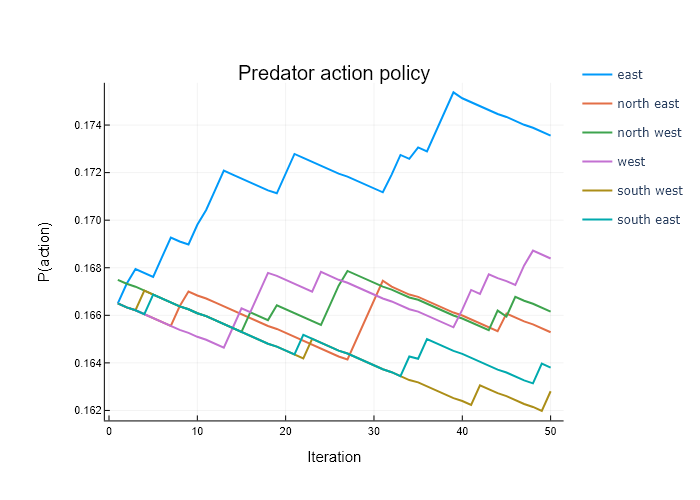

In [21]:
plot(x, pred, title = "Predator action policy", 
label = ["east" "north east" "north west" "west" "south west" "south east"], lw = 2)
xlabel!("Iteration")
ylabel!("P(action)")

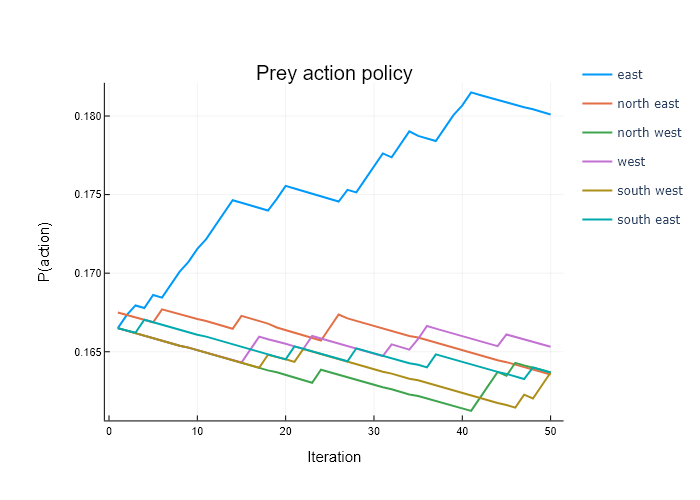

In [22]:
plot(x, prey, title = "Prey action policy", 
label = ["east" "north east" "north west" "west" "south west" "south east"], lw = 2)
xlabel!("Iteration")
ylabel!("P(action)")